# PyTorch

To more conveniently use arrays in Python, we will use the PyTorch numerical computing framework. To install it, go to https://pytorch.org/get-started and follow the instructions for your system. Once we have PyTorch installed, we import `torch` to use PyTorch.

In [1]:
import torch

Install `matplotlib` if necessary, e.g. `pip install matplotlib`

In [2]:
import matplotlib.pyplot as plt

# Gradient descent

Gradient descent is an optimization method that adjusts the parameters of a differentiable function that captures some sort of "loss," or the error of an estimation, in order to optimize it. I'll demonstrate it through a regression task. Regression is predicting a real number or real array.

Suppose there were some function $f$ that maps real numbers to real numbers. That is, $f: \mathbb{R} \to \mathbb{R}$. Let's make an $f$ that is actually $e^x +$ some noise.

In [44]:
def f(x: torch.tensor) -> torch.tensor:
    return torch.exp(x) + 0.1 * torch.randn(len(x))

But let's pretend we don't know that. We only see some examples of $x$ mapped to $y$. Here, I will put them in the form of tuples of $(x, y)$ because that is often how data will be given to you.

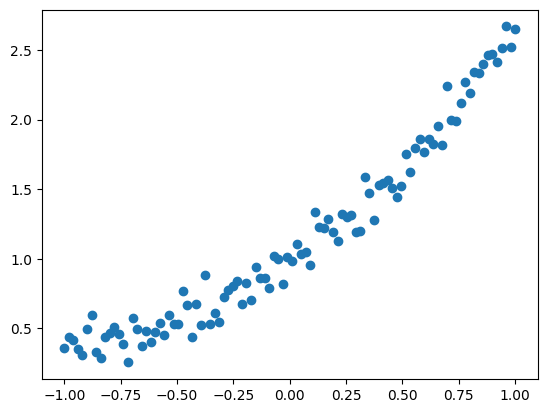

In [45]:
example_inputs = torch.linspace(-1, 1, 100)
observations = tuple(zip(example_inputs, f(example_inputs)))
plt.scatter(*list(zip(*observations)))

## Making a differentiable parameterized function

We will attempt to approximate $f$ using a parameterized differentiable function $\hat{f}$ with much fewer parameters than the number of examples.

> Worth discussing: Why is it desirable to use much fewer parameters than the number of examples?

We will train parameters $\theta$ for $\hat{f}$ to minimize some loss $L$ between $\hat{f}(x)$ and $y$ for all observations $(x, y)$.

We'll make a function such that we can repeatedly adjust $\theta$ against the gradient of $L$ with respect to $\theta$, at some learning rate $\lambda$. That is,

$\theta \gets \theta - \lambda \nabla_\theta L(\hat{f}(X), \mathbf{y})$ repeatedly until we're satisfied.

For now, let $\hat{f}$ be a neural network that takes a single example, which consists of a single number $x$ as input and outputs a number $\hat{y}$. Inside, we can have some small number of artificial neurons. To $x$, each neuron applies a linear transformation $wx + b$, where $w$ and $b$ are parameters $\in \theta$, and then a nonlinear function. A common choice is $\text{ReLU}(x) = \max(0, x)$.

# bookmark

In [4]:
def relu(x: torch.Tensor):
    return max(0, x)

Suppose we use a single hidden layer of 4 neurons inside. To transform an input of size $m$ to an output of size $n$, we must multiply it by a $n \times m$ matrix. Thus, we multiply our single-element input by a $4 \times 1$ matrix, add a $4 \times 1$ matrix, and apply the nonlinear function element-wise.

$Z = \begin{bmatrix}w_{1,1} \\
                    w_{1,2} \\
                    w_{1,3} \\
                    w_{1,4} \end{bmatrix} x + \begin{bmatrix}b_{1,1} \\
                                                             b_{1,2} \\
                                                             b_{1,3} \\
                                                             b_{1,4} \end{bmatrix}$

$A = \text{ReLU}.(Z)$

This intermediate data $A$ is a $4 \times 1$ matrix. To get a single-element output, we must multiply it by a $1 \times 4$ matrix and add a $1 \times 1$ matrix.

$\hat{y} = \begin{bmatrix}w_{2,1} & w_{2,2} & w_{2,3} & w_{2,4}\end{bmatrix} A + \begin{bmatrix}b_2\end{bmatrix}$

Note that for this application, we do not apply a nonlinear function to the output, so it can output negative values.

Let's make the parameters $W_1$, $B_1$ $W_2$ and $B_2$ for $\hat{f}$. We will initialize the $W$s randomly and the $B$s to $0$. To allow us to generalize later, we write these as matrices although we can write them as vectors.

In [5]:
HIDDEN_UNITS = 4

W1 = randn(HIDDEN_UNITS, 1)
B1 = zeros(HIDDEN_UNITS, 1)
W2 = randn(1, HIDDEN_UNITS)
B2 = [0]
;

We can then write $\hat{f}$. In addition to $\hat{y}$, we also return $A$ and $Z$ so we can use them later.

In [6]:
function f_hat(X)
    Z = W1 * X' .+ B1
    A = relu.(Z)
    y_hat = W2 * A .+ B2
    y_hat, A, Z
end
;

This $\hat{f}$ function can handle inputs of different shapes, such as a single example or a batch of examples. Here, we will keep each example as a column so that $X$ has dimensions ($\text{features} \times \text{batch size})$. In practice, it is common to put the batch size as the first dimension of $X$.

For our loss function, we can use the mean squared error $L = \text{MSE}(\hat{\mathbf{y}}, \mathbf{y}) = \dfrac{\sum_{i=1}^{|\mathbf{y}|}(\hat{\mathbf{y}_i} - \mathbf{y}_i)^2}{|\mathbf{y}|}$.

In [7]:
loss(y_hat, y) = sum((y_hat - y) .^ 2) / length(y)
;

To know how to adjust the parameters, we must find the gradient of the loss function with respect to each parameter. Because we can step backwards through the operations using the chain rule, this is called *backpropagation*, while applying $\hat{f}$ is called *forward propagation*. Thus, $\hat{f}$ is commonly named `forward` in numerical computing libraries.

Although in pure math, $\text{ReLU}(x)$ is not differentiable, we treat its derivative as whether $x > 0$.

For $W_1$
> $\nabla_{W_1} L = \dfrac{\partial L}{\partial \hat{\mathbf{y}}}
                                                  \dfrac{\partial \hat{\mathbf{y}}}{\partial A}
                                                  \dfrac{\partial A}{\partial Z}
                                                  \dfrac{\partial Z}{\partial W_1}
                                                = (2(\hat{\mathbf{y}} - \mathbf{y}))\;
                                                  (W_2)\;
                                                  (Z > 0)\;
                                                  (X)$

For $B_1$
> $\nabla_{B_1} L = \dfrac{\partial L}{\partial \hat{\mathbf{y}}}
                                                  \dfrac{\partial \hat{\mathbf{y}}}{\partial A}
                                                  \dfrac{\partial A}{\partial Z}
                                                  \dfrac{\partial Z}{\partial B_1}
                                                = (2(\hat{\mathbf{y}} - \mathbf{y}))\;
                                                  (W_2)\;
                                                  (Z > 0)\;
                                                  (1)$

For $W_2$
> $\nabla_{W_2} L = \dfrac{\partial L}{\partial \hat{\mathbf{y}}}
                                                  \dfrac{\partial \hat{\mathbf{y}}}{\partial W_2}
                                                = (2(\hat{\mathbf{y}} - \mathbf{y}))\;
                                                  (A)$

For $B_2$
> $\nabla_{B_2} L = \dfrac{\partial L}{\partial \hat{\mathbf{y}}}
                                                  \dfrac{\partial \hat{\mathbf{y}}}{\partial B_2}
                                                = (2(\hat{\mathbf{y}} - \mathbf{y}))\;
                                                  (1)$

In [8]:
function ∇_W1_L(X, y_hat, y, Z)
    ∇ = 2 * (y_hat - y')
    ∇ = W2' * ∇
    ∇ = ∇ .* (Z .> 0)
    ∇ = ∇ * X
    ∇ / length(X) # for batch sizes > 1
end

function ∇_B1_L(X, y_hat, y, Z)
    ∇ = 2 * (y_hat - y')
    ∇ = W2' * ∇
    ∇ = ∇ .* (Z .> 0)
    ∇ = ∇ * 1
    ∇ = sum(∇, dims=2)
    ∇ / length(X)
end

function ∇_W2_L(X, y_hat, y, A)
    ∇ = 2 * (y_hat - y')
    ∇ = (A * ∇')'
    ∇ / length(X)
end

function ∇_B2_L(X, y_hat, y)
    ∇ = 2 * (y_hat - y')
    ∇ *= 1
    ∇ = sum(∇, dims=2)
    ∇ / length(X)
end
;

With this information, we can repeatedly update

* $W_1 \gets W_1 - \eta \nabla_{W_1} L$
* $B_1 \gets B_1 - \eta \nabla_{B_1} L$
* $W_2 \gets W_2 - \eta \nabla_{W_2} L$
* $B_2 \gets B_2 - \eta \nabla_{B_2} L$

until we approach the capability of $\hat{f}$ to approximate $f$. In practice, we'll decide a number of epochs to train.

In [9]:
EPOCHS = 100000
LEARNING_RATE = 0.001
;

In [10]:
function gradient_descent()
    for epoch in 1:EPOCHS
        y_hat, A, Z = f_hat(X)
        
        ∇_W1_L_ = ∇_W1_L(X, y_hat, y, Z)
        ∇_B1_L_ = ∇_B1_L(X, y_hat, y, Z)
        ∇_W2_L_ = ∇_W2_L(X, y_hat, y, A)
        ∇_B2_L_ = ∇_B2_L(X, y_hat, y)
        
        global W1 = W1 - LEARNING_RATE .* ∇_W1_L_
        global B1 = B1 - LEARNING_RATE .* ∇_B1_L_
        global W2 = W2 - LEARNING_RATE .* ∇_W2_L_
        global B2 = B2 - LEARNING_RATE .* ∇_B2_L_ 
        
        if epoch % 10000 == 0
            println("Epoch: $epoch. Loss: $(loss(y_hat, y'))")
        end
    end
end
;

Before training, it shouldn't be good at approximating $f$.

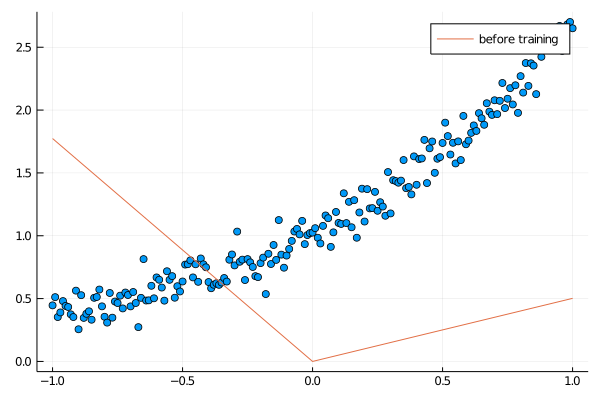

In [11]:
plot!(X, f_hat(X)[1]', label="before training")

In [12]:
gradient_descent()

Epoch: 10000. Loss: 0.01422614027586234
Epoch: 20000. Loss: 0.012403640897640483
Epoch: 30000. Loss: 0.011936475030889399
Epoch: 40000. Loss: 0.011734410542689672
Epoch: 50000. Loss: 0.011520803987374817
Epoch: 60000. Loss: 0.011444364314929399
Epoch: 70000. Loss: 0.011361650164217125
Epoch: 80000. Loss: 0.011276968463903813
Epoch: 90000. Loss: 0.011212341257139095
Epoch: 100000. Loss: 0.011169588662105634


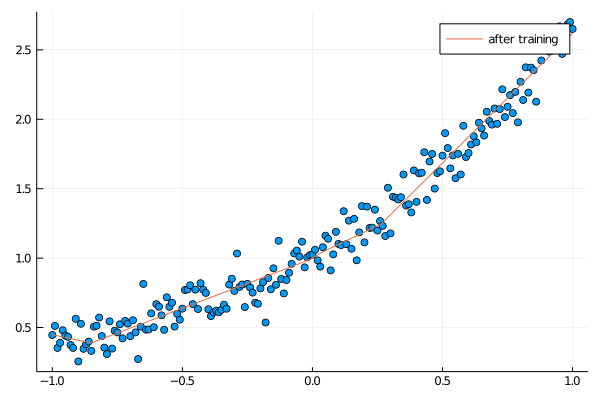

In [13]:
plot(X, y, seriestype = :scatter, label = false)
plot!(X, f_hat(X)[1]', label="after training")

# Stochastic gradient descent

Stochastic gradient descent is just gradient descent, but instead of updating parameters after looking at all examples, you update them after looking at a smaller batch of them. This may be necessary when all training data can't fit into your memory. An epoch is counted when you look at all examples once.

Suppose we use minibatches of size 32.

In [14]:
BATCH_SIZE = 32

X = [x for x in -1:0.01:1]
y = exp.(X) + 0.1 * randn(length(X))

W1 = randn(HIDDEN_UNITS, 1)
B1 = zeros(HIDDEN_UNITS, 1)
W2 = randn(1, HIDDEN_UNITS)
B2 = [0]

minibatches_X = []
for i in 1:BATCH_SIZE:length(X)
    push!(minibatches_X, X[i : min(i + BATCH_SIZE, length(X))])
end

minibatches_y = []
for i in 1:BATCH_SIZE:length(y)
    push!(minibatches_y, y[i : min(i + BATCH_SIZE, length(y))])
end

To show our training progress, we show the sum of the loss over all minibatches.

In [15]:
function stochastic_gradient_descent()
    for epoch in 1:EPOCHS
        loss_ = 0
        for (minibatch_X, minibatch_y) in zip(minibatches_X, minibatches_y)
            y_hat, A, Z = f_hat(minibatch_X)

            ∇_W1_L_ = ∇_W1_L(minibatch_X, y_hat, minibatch_y, Z)
            ∇_B1_L_ = ∇_B1_L(minibatch_X, y_hat, minibatch_y, Z)
            ∇_W2_L_ = ∇_W2_L(minibatch_X, y_hat, minibatch_y, A)
            ∇_B2_L_ = ∇_B2_L(minibatch_X, y_hat, minibatch_y)

            global W1 = W1 - LEARNING_RATE .* ∇_W1_L_
            global B1 = B1 - LEARNING_RATE .* ∇_B1_L_
            global W2 = W2 - LEARNING_RATE .* ∇_W2_L_
            global B2 = B2 - LEARNING_RATE .* ∇_B2_L_
            
            loss_ += loss(y_hat, minibatch_y')
        end
        
        if epoch % 10000 == 0
            println("Epoch: $epoch. Loss: $loss_")
        end
    end
end
;

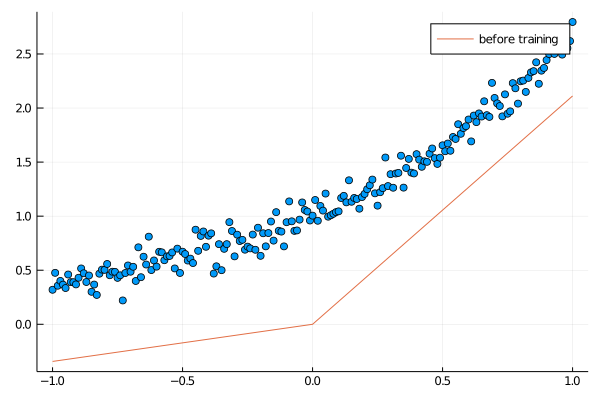

In [16]:
plot(X, y, seriestype = :scatter, label = false)
plot!(X, f_hat(X)[1]', label="before training")

In [17]:
stochastic_gradient_descent()

Epoch: 10000. Loss: 0.062001949353352306
Epoch: 20000. Loss: 0.05973823800057003
Epoch: 30000. Loss: 0.05948579596887798
Epoch: 40000. Loss: 0.05945937660486675
Epoch: 50000. Loss: 0.0594387630858166
Epoch: 60000. Loss: 0.059432267812868964
Epoch: 70000. Loss: 0.059427150945242035
Epoch: 80000. Loss: 0.05942209888489217
Epoch: 90000. Loss: 0.059417118738623535
Epoch: 100000. Loss: 0.059412196567425794


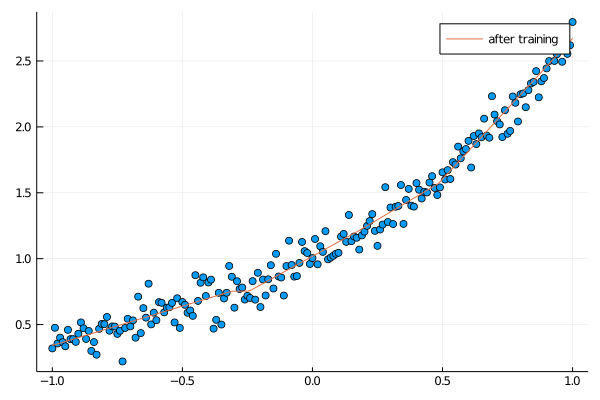

In [18]:
plot(X, y, label=false, seriestype = :scatter)
plot!(X, f_hat(X)[1]', label="after training")